In [174]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data prep

In [199]:
data = pd.read_csv("../0.Data/questions.csv")
data = data.iloc[:,3:]
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

sents = data['question1'].values.tolist()
sents.extend(data['question2'].values.tolist())

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sents)
data['q1_tokenized'] = tokenizer.texts_to_sequences(data['question1'])
data['q2_tokenized'] = tokenizer.texts_to_sequences(data['question2'])


Max lenth of sequences chosen:  75


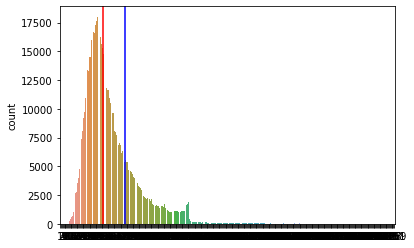

In [176]:
plt.axvline(50, c='red')
plt.axvline(75, c='blue')
sns.countplot(pd.Series([len(x) for x in sents]))
MAX_LEN = 75
print("Max lenth of sequences chosen: ", MAX_LEN)

In [200]:
def pad_sequences(text):

    if len(text) <= MAX_LEN:
        text.extend([0]*(MAX_LEN - len(text)))
    else:
        text = text[:MAX_LEN]

    return text

In [201]:
data['q1_tokenized'] = data['q1_tokenized'].apply(pad_sequences)
data['q2_tokenized'] = data['q2_tokenized'].apply(pad_sequences)

14
here
[2, 3, 1, 1228, 57, 1228, 2582, 7, 575, 8, 763, 383, 8, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10
here
[2, 3, 1, 558, 10, 14302, 13600, 5, 21317, 4565, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
14
here
[4, 13, 5, 217, 1, 440, 10, 17, 361, 1827, 200, 146, 6, 2773, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11
here
[16, 72, 5, 2774, 307, 2757, 4, 13, 5, 648, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['q1_tokenized','q2_tokenized']], data['is_duplicate'], stratify=data['is_duplicate'], random_state=42, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, stratify=y_train)

In [ ]:
trainset = tf.data.Dataset.from_tensor_slices((X_train,y_train)) #.batch(batch_size=64).shuffle(buffer_size=5)
# validationset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(batch_size=64)
# testset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size=64)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

# Model

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.TextVectorization(output_sequence_length = 64, max_tokens=10000),
        tf.keras.layers.Embedding(input_dim = 100000, output_dim = 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation = 'leaky_relu'),
        tf.keras.layers.Dense(128, activation = 'leaky_relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation = 'leaky_relu'),
        tf.keras.layers.Dense(1, activation = 'leaky_relu'),
    ]
)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics = 'accuracy',
    loss = tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
model.fit(trainset,
epochs=10,
validation_data = validationset,
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]
)

Epoch 1/10


RuntimeError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/layers/preprocessing/text_vectorization.py", line 446, in build
        raise RuntimeError(

    RuntimeError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    When using TextVectorization to tokenize strings, the innermost dimension of the input array must be 1, got shape (None, 2)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 2), dtype=string)
      • training=True
      • mask=None


In [ ]:
next(iter(trainset))

(<tf.Tensor: shape=(64, 2), dtype=string, numpy=
 array([[b'How one should prepare for getting admission in FMS Delhi?',
         b'Does FMS [Faculty of Management Studies, New Delhi] accept only the CAT or the GMAT for admission into its MBA course?'],
        [b'Is there any harm in not masturbating?',
         b'Is there any harm in masturbating?'],
        [b'Does Donald Trump still have a chance of winning? (October 15, 2016)',
         b'Does Donald Trump have any chance of winning the forthcoming election?'],
        [b'What are the places to visit in Chennai?',
         b'What is a good place to visit in Chennai with your lover?'],
        [b'How can I become taller at 19?',
         b'How can I become taller at 18?'],
        [b'How can I view deleted Instagram dms?',
         b'How can I delete cache for Instagram?'],
        [b"Me and my boyfriend are breaking up cause we don't have future, should I move on or wait for him to come back resolving his problems What should I do